In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [6]:
frequencies_df=pd.read_csv('frequencies.txt')
routes_df=pd.read_csv('routes.txt')
trips_df=pd.read_csv('trips.txt')
stops_df=pd.read_csv('stops.txt')
stop_times_df=pd.read_csv('stop_times.txt')
shapes_df=pd.read_csv('shapes.txt')
agency_df=pd.read_csv('agency.txt')
feed_info_df=pd.read_csv('feed_info.txt')
calendar_df=pd.read_csv('calendar.txt')
calendar_dates_df=pd.read_csv('calendar_dates.txt')

In [7]:
frequencies_df.head(5)

,trip_id,start_time,end_time,headway_secs
0,10106110,06:00:00,09:00:00,300
1,10106110,09:00:00,15:00:00,900
2,10106110,15:00:00,21:00:00,300
3,10106111,06:00:00,09:00:00,300
4,10106111,09:00:00,15:00:00,900


In [8]:
# Check for missing values in all dataframes
for name, df in {
    "frequencies": frequencies_df,
    "routes": routes_df,
    "trips": trips_df,
    "stops": stops_df,
    "stop_times": stop_times_df,
    "shapes": shapes_df,
    "agency": agency_df,
    "feed_info": feed_info_df,
    "calendar": calendar_df,
    "calendar_dates": calendar_dates_df
}.items():
    print(f"\n{name.upper()} - Missing values:")
    print(df.isnull().sum())



FREQUENCIES - Missing values:
trip_id         0
start_time      0
end_time        0
headway_secs    0
dtype: int64

ROUTES - Missing values:
route_id            0
agency_id           0
route_short_name    0
route_long_name     0
route_type          0
dtype: int64

TRIPS - Missing values:
route_id         0
service_id       0
trip_id          0
trip_headsign    0
direction_id     0
shape_id         0
dtype: int64

STOPS - Missing values:
stop_id              0
stop_name            0
stop_lat             0
stop_lon             0
location_type     4221
parent_station    4254
dtype: int64

STOP_TIMES - Missing values:
trip_id           0
arrival_time      0
departure_time    0
stop_id           0
stop_sequence     0
dtype: int64

SHAPES - Missing values:
shape_id             0
shape_pt_lat         0
shape_pt_lon         0
shape_pt_sequence    0
dtype: int64

AGENCY - Missing values:
agency_id          0
agency_name        0
agency_url         0
agency_timezone    0
agency_lang        0
ag

In [9]:
# Drop missing lat/lon and remove out-of-range coordinates
stops_df = stops_df.dropna(subset=['stop_lat', 'stop_lon'])
stops_df = stops_df[
    (stops_df['stop_lat'].between(-90, 90)) & 
    (stops_df['stop_lon'].between(-180, 180))
]


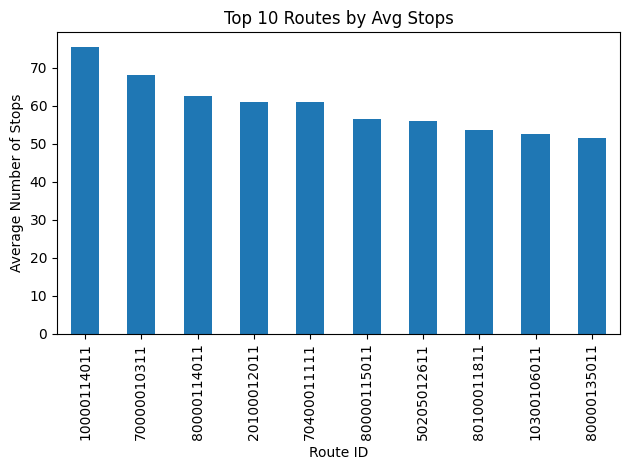

In [10]:
import matplotlib.pyplot as plt

# Merge trips with stop_times to count stops per trip
trip_stop_counts = stop_times_df.groupby('trip_id')['stop_id'].count().reset_index(name='num_stops')
trips_with_stops = pd.merge(trips_df, trip_stop_counts, on='trip_id')
route_stop_counts = trips_with_stops.groupby('route_id')['num_stops'].mean()

# Plot top 10 routes by average number of stops
route_stop_counts.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Routes by Avg Stops')
plt.xlabel('Route ID')
plt.ylabel('Average Number of Stops')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Matatu Stops Location')

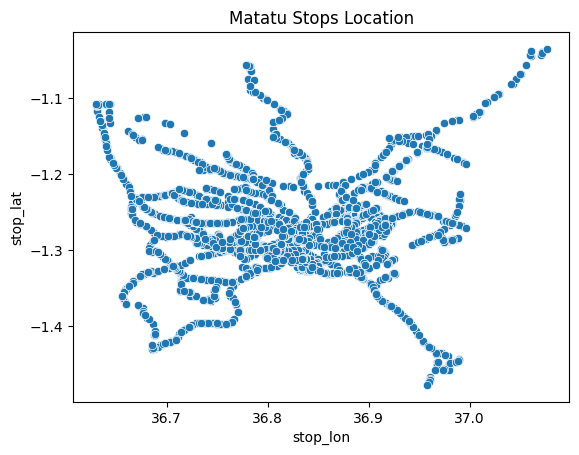

In [12]:
import seaborn as sns

sns.scatterplot(data=stops_df, x='stop_lon', y='stop_lat').set_title('Matatu Stops Location')


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

coords = stops_df[['stop_lat', 'stop_lon']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

kmeans = KMeans(n_clusters=5, random_state=0)
stops_df['zone'] = kmeans.fit_predict(coords_scaled)


In [15]:
from sklearn.metrics import silhouette_score

score = silhouette_score(coords_scaled, stops_df['zone'])
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.34


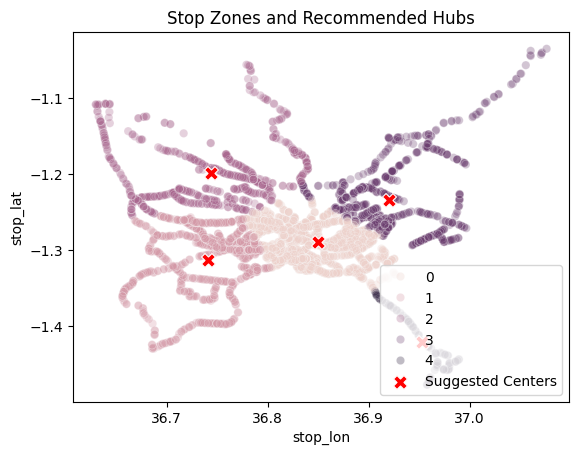

In [16]:
def recommend_new_stops(df, cluster_col='zone'):
    return df.groupby(cluster_col)[['stop_lat', 'stop_lon']].mean().reset_index()

centroids_df = recommend_new_stops(stops_df)

sns.scatterplot(x='stop_lon', y='stop_lat', data=stops_df, hue='zone', alpha=0.3)
sns.scatterplot(x='stop_lon', y='stop_lat', data=centroids_df, marker='X', color='red', s=100, label='Suggested Centers')
plt.legend()
plt.title("Stop Zones and Recommended Hubs")
plt.show()


In [17]:
# Save stops_df with clustering info
stops_df.to_csv('stops_cleaned_zones.csv', index=False)


In [18]:
routes_df.to_csv('routes_cleaned.csv', index=False)


In [19]:
trips_df.to_csv('trips_cleaned.csv', index=False)


In [20]:
stop_times_df.to_csv('stop_times_cleaned.csv', index=False)


In [21]:
calendar_df.to_csv('calendar_cleaned.csv', index=False)


In [22]:
centroids_df = recommend_new_stops(stops_df)
centroids_df.to_csv('recommended_stop_centers.csv', index=False)
